In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from load_data import *
from flow_catlog import *
import flow_manager as fm
import autoencoder as ae
import classifier as clfr
from sampler import *
from utl import *
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tensorflow.compat.v1 import logging
import math
logging.set_verbosity(logging.ERROR)

In [2]:
DTYPE=tf.float32
NP_DTYPE=np.float32
num_bijectors = 6
steps = 2000
lr = 1e-3
datafile = 'machine-1-1.csv'

In [3]:
X_data = pd.read_csv(datafile, header=None)
# X_data = X_data.iloc[:3000]

IndexError: index 14 is out of bounds for axis 1 with size 14

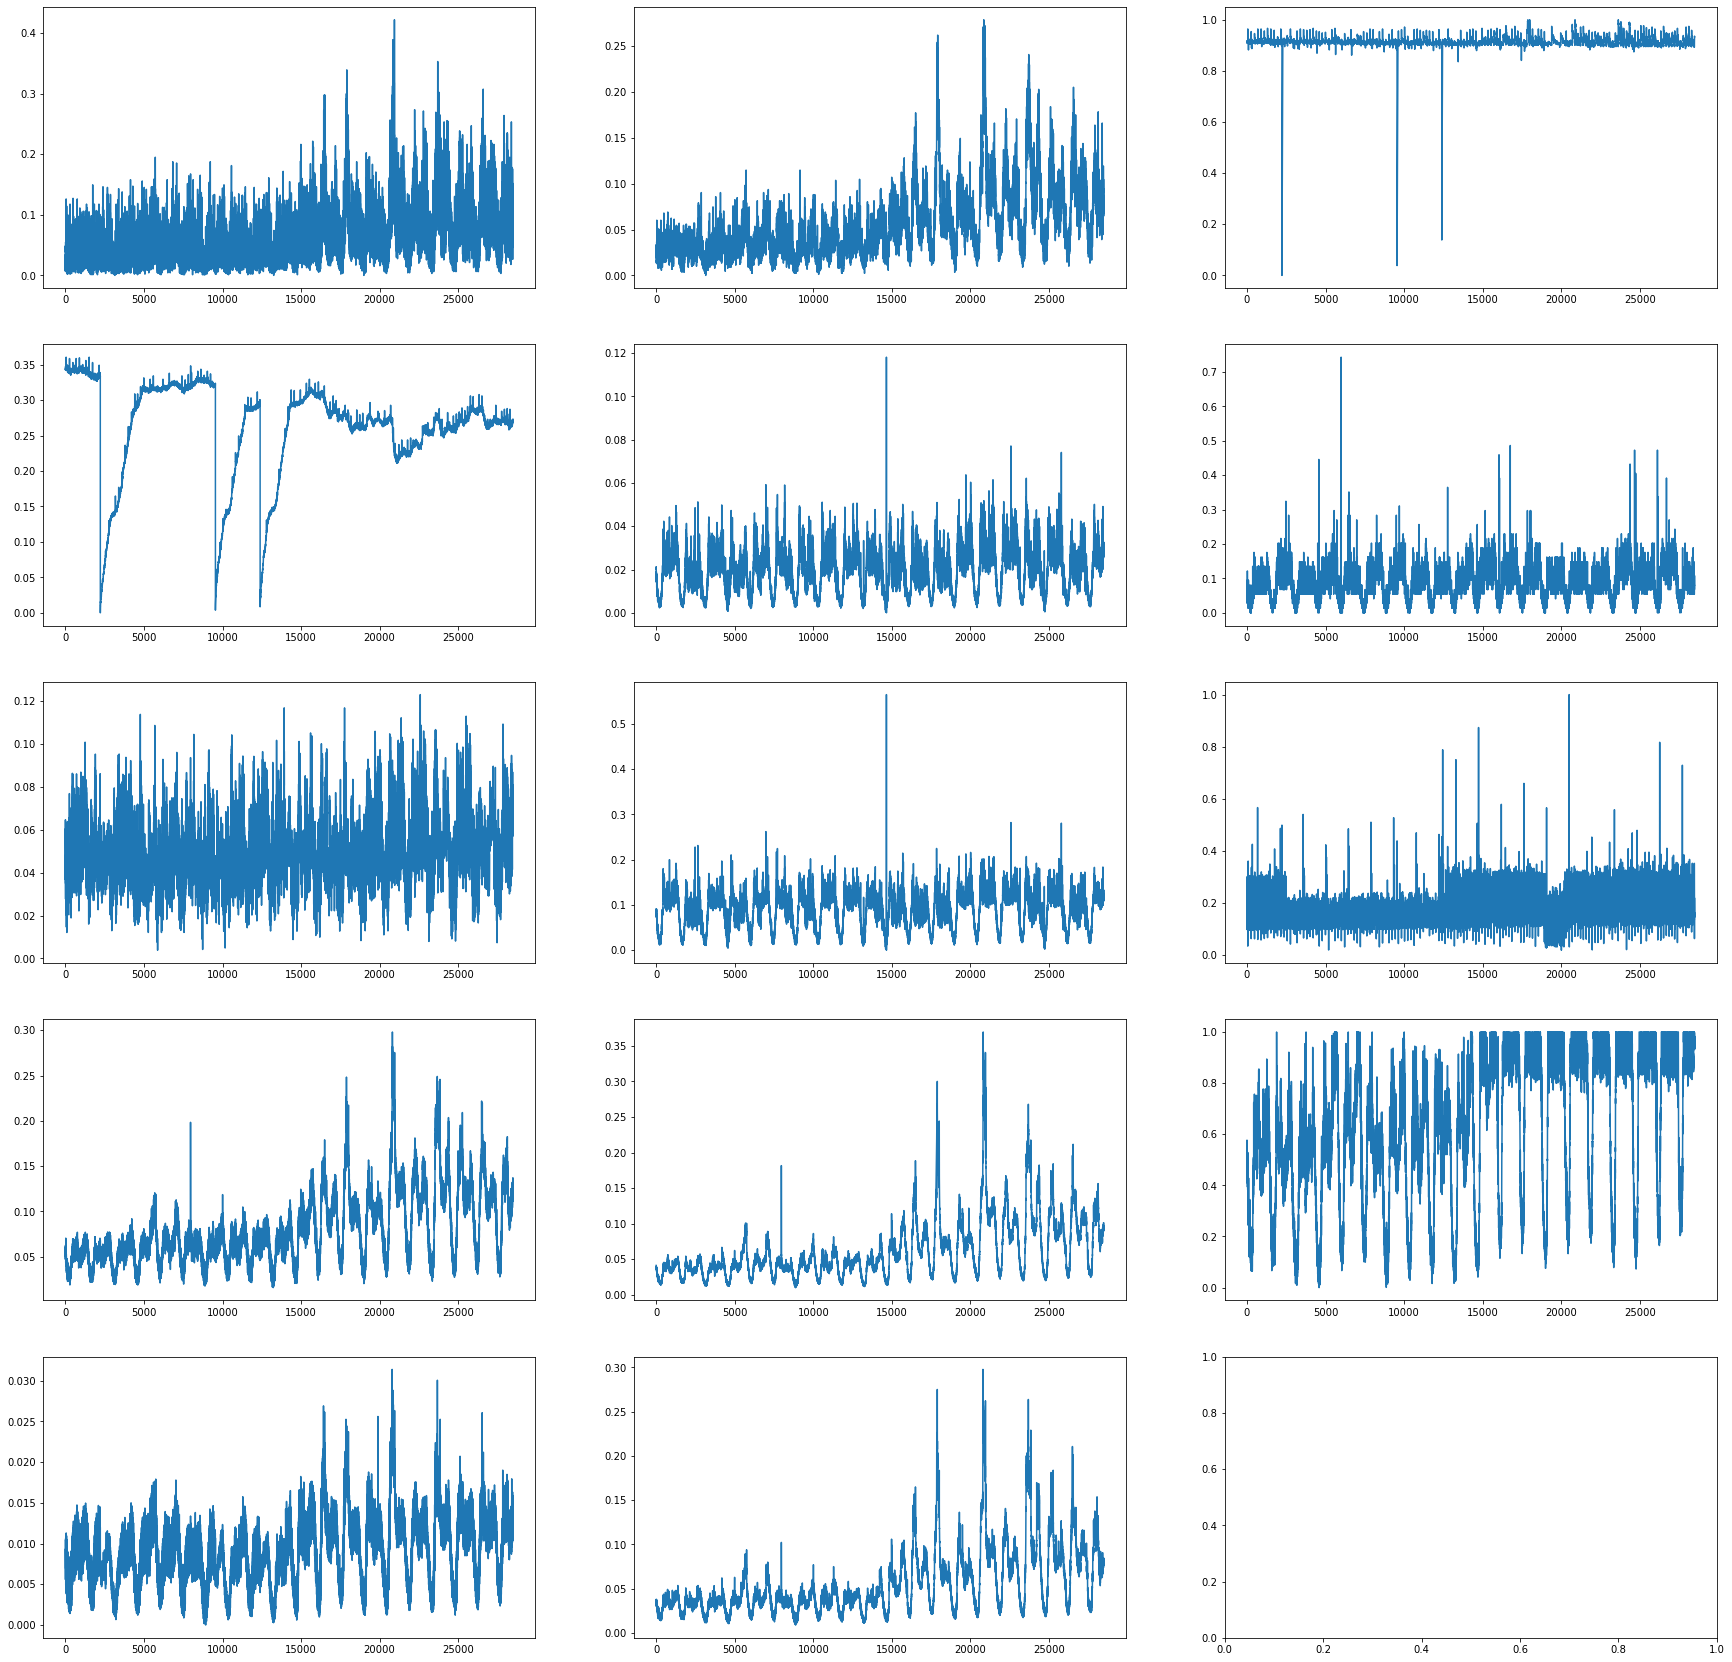

In [4]:
fig, ax = plt.subplots(nrows=math.ceil(X_data.shape[1]/3), ncols=3, figsize=(30,30))
for i in range(math.ceil(X_data.shape[1]/3)):
    for j in range(3):
        ax[i][j].plot(X_data.values[:, i*3+j])

plt.tight_layout()
plt.show()

In [5]:
X_data = X_data.values.astype(np.float32)
X_data = MinMaxScaler().fit_transform(X_data)

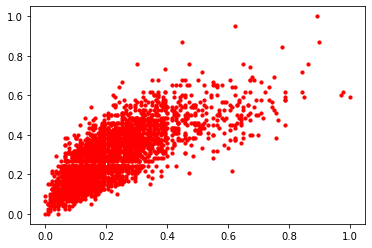

In [6]:
# Plot joint distribution
plt.scatter(X_data[:, 0], X_data[:, 1], s=10, color='red')

In [7]:
# sample from the base distribution

input_dims = X_data.shape[1]
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([input_dims], tf.float32))
activation = tf.nn.relu
flow = IAF(base_dist, num_bijectors, hidden_units=[256, 256], ndims=input_dims, activation=activation)

# Training an IAF Flow

steps: 0 	 loss: 14.756375
steps: 100 	 loss: -14.687891
steps: 200 	 loss: -19.085379
steps: 300 	 loss: -18.851068
steps: 400 	 loss: -20.151167
steps: 500 	 loss: -15.490795
steps: 600 	 loss: -19.915693
steps: 700 	 loss: -20.913908
steps: 800 	 loss: -21.910572
steps: 900 	 loss: -20.528679
steps: 1000 	 loss: -21.41111
steps: 1100 	 loss: -21.876331
steps: 1200 	 loss: -20.841362
steps: 1300 	 loss: -23.01789
steps: 1400 	 loss: -22.154078
steps: 1500 	 loss: -15.6098995
steps: 1600 	 loss: -23.13434
steps: 1700 	 loss: -23.453625
steps: 1800 	 loss: -20.305481
steps: 1900 	 loss: -23.854765


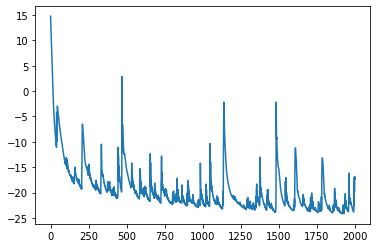

In [8]:
losses = fm.train_dist_routine(X_data, flow, learning_rate=lr, steps=steps)
plt.plot(losses)

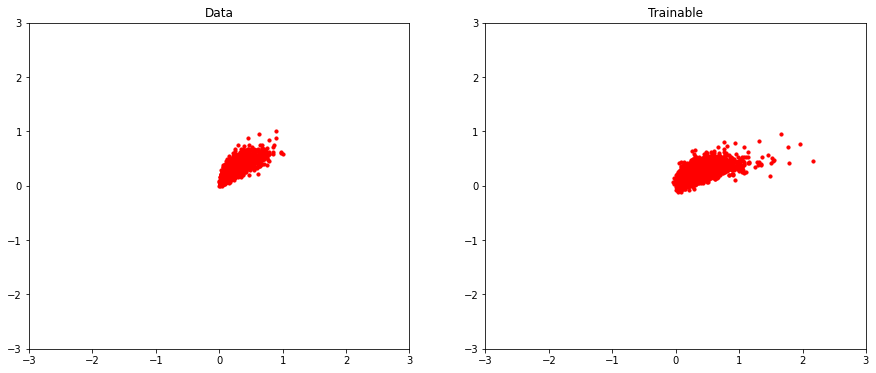

In [9]:
# Make samples
names, samples = make_samples(base_dist, flow, n_samples=X_data.shape[0])
visualize_training_data(X_data, samples)

ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 14 but received input with shape (100, 100, 2)

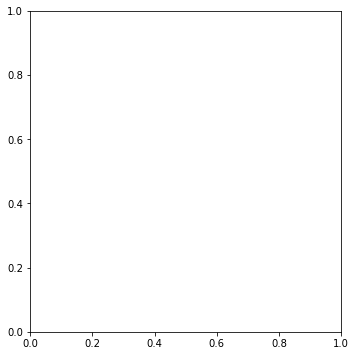

In [10]:
plot_contour_prob([flow], scale_fig=6)

In [ ]:
# TODO: how to determin the threshold?
anomalies = detect_anomalies(data=X_data, model=flow, threshold=0.01)
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(len(X_data[:, 0]))
axes[0].plot(x, X_data[:, 0], color='red', zorder=0)
axes[0].scatter(anomalies, X_data[anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_data[:, 1], color='red', zorder=0)
axes[1].scatter(anomalies, X_data[anomalies, 1], color='blue', s=10, zorder=1)

plt.show()

# Data Distribution Before/After Training

In [ ]:
temp = flow.bijector.inverse(X_data).numpy()

## Before

In [ ]:
fig, axes = plt.subplots(2)
axes[0].hist(temp[:, 0], bins=100, density=True)
axes[1].hist(temp[:, 1], bins=100, density=True)
plt.show()

## After

In [ ]:
fig, axes = plt.subplots(2)
axes[0].hist(X_data[:, 0], bins=100, density=True)
axes[1].hist(X_data[:, 1], bins=100, density=True)
plt.show()

# Generate Data for the Classifier

In [ ]:
factor = 2
anomalies = sample_anomalies(flow, factor=factor, n_samples=3000)
normals = sample_normals(flow, factor=factor, n_samples=10000)

In [ ]:
anomalies = pd.DataFrame(anomalies)
normals = pd.DataFrame(normals)
anomalies.columns = ['v1', 'v2']
normals.columns = ['v1', 'v2']
anomalies['label'] = 1
normals['label'] = 0

In [ ]:
clr_data = pd.concat([anomalies, normals], axis=0)
clr_data = clr_data.dropna()
clr_data = shuffle(clr_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clr_data[['v1', 'v2']], clr_data['label'], test_size=0.33, random_state=42)
clf, score = clfr.RFClassifier(X_train, y_train, X_test, y_test)
print('precision: {}'.format(score[0]))
print('recall: {}'.format(score[1]))
print('fscore: {}'.format(score[2]))
print('support: {}'.format(score[3]))

# Apply Classifier on Real Data

In [ ]:
y_data = clf.predict(X_data)
y_data_anomalies = np.where(y_data == 1)

In [ ]:
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(len(X_data[:, 0]))
axes[0].plot(x, X_data[:, 0], color='red', zorder=0)
axes[0].scatter(y_data_anomalies, X_data[y_data_anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_data[:, 1], color='red', zorder=0)
axes[1].scatter(y_data_anomalies, X_data[y_data_anomalies, 1], color='blue', s=10, zorder=1)

plt.show()